In [1]:
import sys  
sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
import networkx as nx
from scipy import sparse, linalg
import pickle
from sklearn.preprocessing import normalize, scale
from scipy.sparse import find
from numpy.linalg import norm
import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors


In [58]:
size = 100000
dirpath = '../data/TCGA-MP-A4TJ-01Z-00-DX1.14EDBE5C-5D0C-4002-BE95-AF5C9D9F3D43.svs.tar.gz'

nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well

num_cores = multiprocessing.cpu_count() # numb of cores

sample = os.path.basename(dirpath).split(sep='.')[0]; print(sample)

print('Loading the data')
df = pd.DataFrame()
fovs = glob.glob(dirpath+'/*_polygon/*.svs/*.csv.morphometrics.pkl')

print('There are '+str(len(fovs))+' FOVs')
for fov in fovs: # for each fov
    data = pd.read_pickle(fov)
    df = df.append(data, ignore_index = True)

df['area'] = df['area'].astype(float) # convert to float this field

#df = df.head(n=200000) # hard-coded downsize for memory issues 
numb_nuclei = df.shape[0] 
print(str(numb_nuclei)+' nuclei')
    
if size == 0 or size > df.shape[0]:
    print('Considering all nuclei')
    size = 0
    fdf = df 
else:
    print('Downsampling '+str(size)+' nuclei')
    fdf = df.sample(n=size,random_state=1234) #!!!hard-coded random state 

TCGA-MP-A4TJ-01Z-00-DX1
Loading the data
There are 440 FOVs
2198499 nuclei
Downsampling 100000 nuclei


In [59]:
print('Creating the UMAP graph')
centroids = df.columns[:2];# print(centroids)
pos = fdf[centroids].to_numpy(dtype='float') # Get the positions of centroids 
A = space2graph(pos,nn)
print('Characterizing the neighborhood')
X = df[centroids].to_numpy() # the full array of position
if size is not 0:
    n_neighbors = df.shape[0]//size + 10
else:
    n_neighbors = 10    
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',n_jobs=-1).fit(X) 
distances, indices = nbrs.kneighbors(X) 

#get the morphological data and rescale the data by std
df['circularity'] = 4.0*np.pi*df['area'] / (df['perimeter']*df['perimeter'])
features = ['area', 'eccentricity', 'orientation','perimeter', 'solidity','circularity']

data = df[features].to_numpy(); #print(data.shape)
    
# Parallel generation of the local covd
filename = dirpath+'/'+sample+'.nuclei'+str(numb_nuclei)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.descriptors.pkl'
if not os.path.exists(filename):
    print('Generating the descriptor')
    processed_list = Parallel(n_jobs=num_cores)(
        delayed(covd_parallel_sparse)(node,data,indices) for node in tqdm(list(fdf.index))
    )
    pickle.dump( processed_list, open( filename, "wb" ) )
else:
    print('Loading the descriptor')
    processed_list = pickle.load( open( filename, "rb" ) )

Creating the UMAP graph
Characterizing the neighborhood


  0%|          | 0/100000 [00:00<?, ?it/s]

Generating the descriptor


100%|██████████| 100000/100000 [03:13<00:00, 517.61it/s]


In [60]:
    
nodes_with_covd = [l[0] for l in processed_list if l[2] == 0] # list of nodes with proper covd
nodes_wo_covd = [l[0] for l in processed_list if l[2] == 1] # list of nodes wo covd
fdf['covd'] = [0 for i in range(fdf.shape[0])]
fdf.loc[nodes_wo_covd,'covd'] = 0 # identify nodes wo covd in dataframe
fdf.loc[nodes_with_covd,'covd'] = 1 # identify nodes with covd in dataframe
    
print('There are '+str(len(nodes_with_covd))+' nodes with covd properly defined')

There are 98300 nodes with covd properly defined


In [61]:
# Construct the descriptor array
descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]),dtype=complex)
counter = 0
for r in range(len(processed_list)):
    if sum(np.isnan(processed_list[r][1])):
        counter += 1
        descriptor[r,:] = np.zeros(processed_list[r][1].shape)
    else:
        descriptor[r,:] = processed_list[r][1] 
print(counter)

1700


In [62]:
mean_covd = np.mean(descriptor,axis=0)

In [63]:
from numpy import linalg as LA
delta = descriptor-mean_covd
distance_from_barycenter = LA.norm(delta,axis=1)

In [64]:
fdf['heterogeneity'] = distance_from_barycenter

In [69]:
#Show contour plot
N = 100
filename = dirpath+'/'+sample+'.nuclei'+str(numb_nuclei)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.contour.baryDist.mean.png'
contourPlot(fdf[fdf['covd']==True],N,np.mean,filename)


In [103]:
#Show contour plot
N = 100
filename = 'test.mean'
contourPlot(fdf[(fdf['covd']==True) & (fdf['heterogeneity']>0)],N,np.mean,filename)

In [83]:
fdf[(fdf['covd']==True) & (fdf['heterogeneity']>2)].shape

(25, 9)

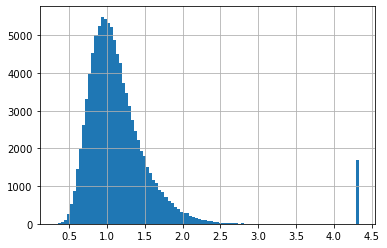

In [75]:
fdf['heterogeneity'].hist(bins=100)